In [93]:
from webbrowser import BaseBrowser
import pandas as pd

benchmarkVersion = "v9"

benchmarks = [ "speech-tag", "text-to-p",  "shakespearean-writing-assistant", "sentence-rewrite", "extract-names", "elements", "art-prompt", "classify-input-text"   ]

#benchmarks = [ "speech-tag", "text-to-p", "sentence-rewrite", "extract-names", "elements", "art-prompt", "classify-input-text"   ]
#benchmarks = [ "speech-tag", "text-to-p", "sentence-rewrite", "extract-names", "elements",    ]
# benchmarks = [ "speech-tag", "text-to-p", ]


prettyNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}


### Add proper columns to the dataframe

data = {}
comp_val = {}
base_comp_val = {}
pos_comp_val = {}
neg_comp_val = {}

for benchmark in benchmarks:
    # print("benchmark: ", benchmark)
    data[benchmark] = pd.read_csv(f'evals/{benchmarkVersion}/{benchmark}/overview.csv')
    db = data[benchmark]
    
    db["compliant %"] = [float(p.strip('%')) / 100 for p in db["tests compliant"]]
    db["baseline %"] = [float(p.strip('%')) / 100 for p in db["baseline compliant"]]
    db["pos rule %"] = db["tests positive compliant"] / db["tests positive"]
    db["neg rule %"] = db["tests negative compliant"] / db["tests negative"]
    db["valid test %"] = db["tests valid"] / db["tests"]
    
    comp_val[benchmark] = db["compliant %"]
    base_comp_val[benchmark] = db["baseline %"]
    pos_comp_val[benchmark] = db["pos rule %"]
    neg_comp_val[benchmark] = db["neg rule %"]
    
    #print(db["compliant %"])
    #print(db["baseline %"])
    #print(db["pos rule %"])
    #print(db["neg rule %"])
    #print(db["valid test %"])


# zero out the sum
n_models = len(data[benchmarks[0]]["model"])
comp_val["sum"] = [0 for i in range(n_models)]
base_comp_val["sum"] = [0 for i in range(n_models)]
pos_comp_val["sum"] = [0 for i in range(n_models)]
neg_comp_val["sum"] = [0 for i in range(n_models)]

# sum up the values across the benchmarks
for key in comp_val:
    if (key != "sum"):
        print("key:", key)
        comp_val["sum"] = comp_val["sum"] + comp_val[key]
        base_comp_val["sum"] = base_comp_val["sum"] + base_comp_val[key]
        pos_comp_val["sum"] = pos_comp_val["sum"] + pos_comp_val[key]
        neg_comp_val["sum"] = neg_comp_val["sum"] + neg_comp_val[key]
        # print('neg_comp_val["sum"]', neg_comp_val["sum"])

# calculate the mean
#print('comp_val["sum"]', comp_val["sum"])
comp_val["mean"] = comp_val["sum"]/len(benchmarks)
#print('comp_val["mean"]', comp_val["mean"])
base_comp_val["mean"] = base_comp_val["sum"]/len(benchmarks)
pos_comp_val["mean"] = pos_comp_val["sum"]/len(benchmarks)
#print('neg_comp_val["sum"]', neg_comp_val["sum"])
neg_comp_val["mean"] = neg_comp_val["sum"]/len(benchmarks)
#print('neg_comp_val["mean"]', neg_comp_val["mean"])
    
    
###############################################################################
### Generate graphs from the data


### Generate a csv with the compliance % per benchmark for promptpex
###
    
with open(f'evals/{benchmarkVersion}/pp-cpct.csv', 'w') as cfile:
    print("Benchmark,", end="", file=cfile)
    # just need the model names from the first benchmark
    db = data["speech-tag"] 
    print(', '.join(map(str, db["model"])), file=cfile)
        
    for benchmark in benchmarks:
        print(prettyNames[benchmark], ",", end="", file=cfile)
        db = data[benchmark]
        print(', '.join(map(str, db["compliant %"])), file=cfile)
    
    print("average", ",", end="", file=cfile)
    print(', '.join(map(str, comp_val["mean"])), file=cfile)

### Generate a csv with the test validity per benchmark for promptpex
###
    
with open(f'evals/{benchmarkVersion}/pp-test-validity.csv', 'w') as cfile:
    print("Benchmark, tests, valid tests", file=cfile)
        
    for benchmark in benchmarks:
        db = data[benchmark]
        print(f'{prettyNames[benchmark]},{db["tests"][0]}, {db["tests valid"][0]}', file=cfile)

### Generate a csv comparing positive and negative compliance per model and benchmark for promptpex
###

with open(f'evals/{benchmarkVersion}/pos-neg-cpct.csv', 'w') as cfile:
    
    models = data[benchmarks[0]]["model"]
    pos_sum = [0 for i in range(len(models))]
    neg_sum = [0 for i in range(len(models))]    
    
    print("Benchmark, Rule % Compliance, Inv Rule % Compliance", file=cfile)

    for b in benchmarks:
        db = data[b]
        #print(db["pos rule %"])
        pos_sum += db["pos rule %"]
        neg_sum += db["neg rule %"]
            
    for m, psum, nsum in zip(models, pos_sum, neg_sum):
        print(m, ",", psum/len(benchmarks), ",", nsum/len(benchmarks), file=cfile)
        
    
    #print("average", ",", end="", file=cfile)
    #print(pos_comp_val["mean"], ",", neg_comp_val["mean"], file=cfile)

### Generate a csv with the average compliance of promptpex versus baseline
# each row is a model
# each column is a method (pp vs baseline)

with open(f'evals/{benchmarkVersion}/pp-compare.csv', 'w') as cfile:
    
    models = data[benchmarks[0]]["model"]
    pp_sum = [0 for i in range(len(models))]
    bl_sum = [0 for i in range(len(models))]    
    
    print("Benchmark, PromptPex Compliance %, Baseline Compliance %", file=cfile)

    for b in benchmarks:
        db = data[b]
        #print(db["pos rule %"])
        pp_sum += db["compliant %"]
        bl_sum += db["baseline %"]
            
    for m, psum, bsum in zip(models, pp_sum, bl_sum):
        print(m, ",", psum/len(benchmarks), ",", bsum/len(benchmarks), file=cfile)



key: speech-tag
key: text-to-p
key: shakespearean-writing-assistant
key: sentence-rewrite
key: extract-names
key: elements
key: art-prompt
key: classify-input-text


In [94]:
### Extract out number of rules and grounded rules per benchmark

import re

grules = {}


with open(f'evals/{benchmarkVersion}/pp-grounded-rules.csv', 'w') as cfile:
    print(f"benchmark, rules, grounded rules", file=cfile)
    for benchmark in benchmarks:
    # Read the file content
        with open(f'/workspaces/promptpex/evals/{benchmarkVersion}/{benchmark}/README.md', 'r') as file:
            content = file.read()

        # Extract the line
        match = re.search(r'- (\d+) rules, (\d+)/(\d+) \(\d+%\) grounded', content)
        if match:
            n1 = int(match.group(2))
            n2 = int(match.group(3))
        else:
            n1 = 0
            n2 = 0
        print(f"{prettyNames[benchmark]}, {n2}, {n1}", file=cfile)


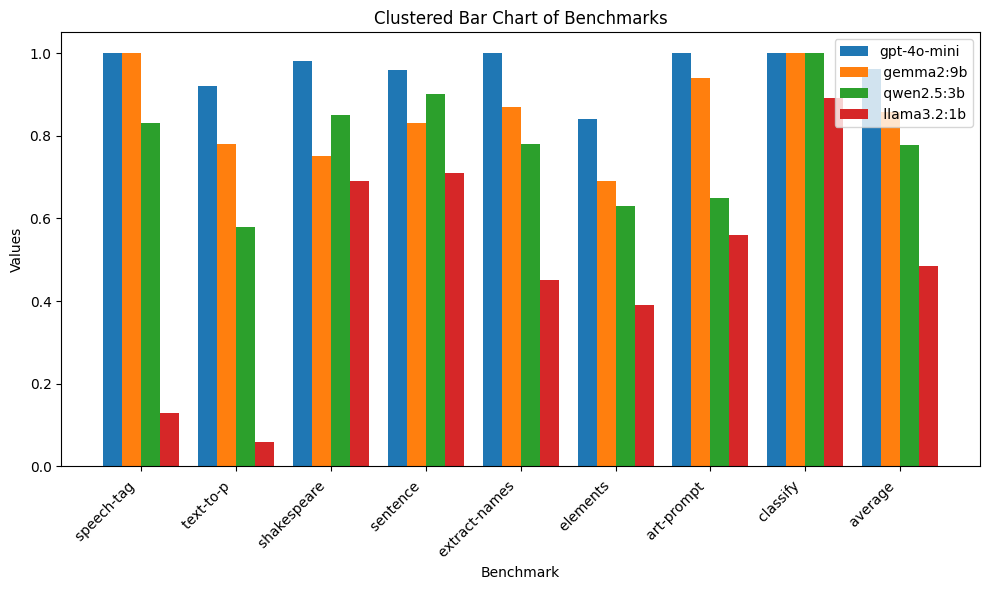

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv(f'evals/{benchmarkVersion}/pp-cpct.csv')

# Remove the 'average' row if present
df = df[df['Benchmark'] != 'average']

# Set the 'Benchmark' column as the index
df.set_index('Benchmark', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Number of benchmarks
n_benchmarks = len(df.index)
# Number of models
n_models = len(df.columns)

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
indices = np.arange(n_benchmarks)

# Plot each model's bars
for i, model in enumerate(df.columns):
    ax.bar(indices + i * bar_width, df[model], bar_width, label=model)

# Set the x-axis labels
ax.set_xticks(indices + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(df.index, rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Values')
ax.set_title('Clustered Bar Chart of Benchmarks')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

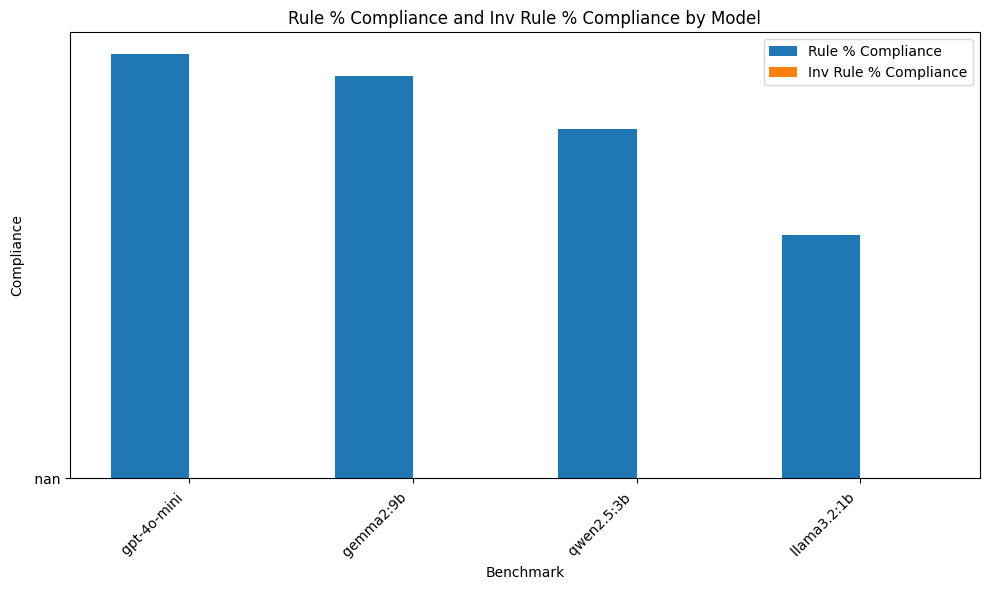

In [96]:
# Load the CSV file into a DataFrame
df = pd.read_csv(f'evals/{benchmarkVersion}/pos-neg-cpct.csv')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
indices = range(len(df))

# Plot each compliance type's bars
ax.bar(indices, df[' Rule % Compliance'], bar_width, label='Rule % Compliance')
ax.bar([i + bar_width for i in indices], df[' Inv Rule % Compliance'], bar_width, label='Inv Rule % Compliance')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df['Benchmark'], rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Compliance')
ax.set_title('Rule % Compliance and Inv Rule % Compliance by Model')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

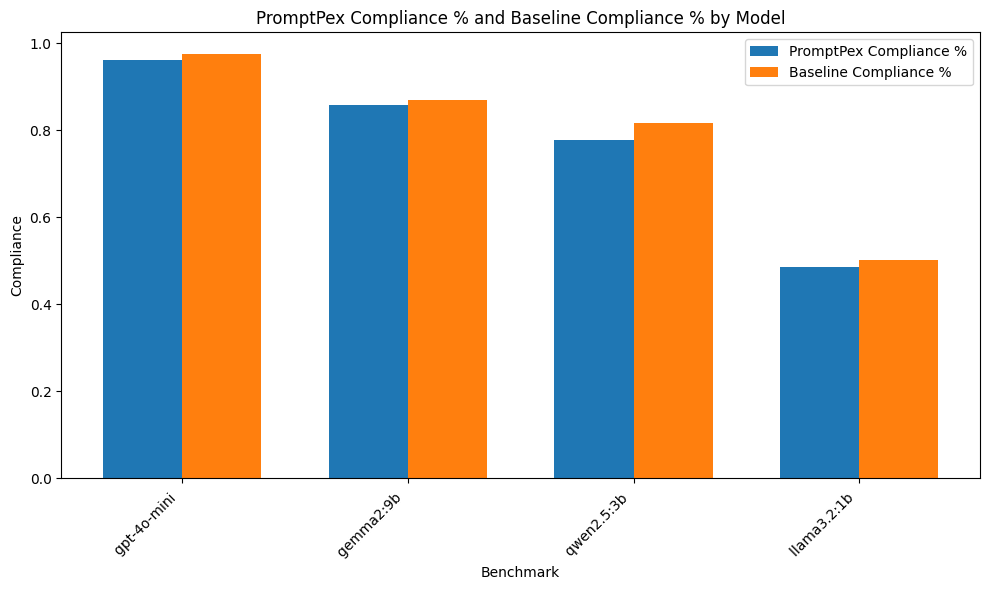

In [97]:
# Load the CSV file into a DataFrame
df = pd.read_csv(f'evals/{benchmarkVersion}/pp-compare.csv')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
indices = range(len(df))

# Plot each compliance type's bars
ax.bar(indices, df[' PromptPex Compliance %'], bar_width, label='PromptPex Compliance %')
ax.bar([i + bar_width for i in indices], df[' Baseline Compliance %'], bar_width, label='Baseline Compliance %')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df['Benchmark'], rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Compliance')
ax.set_title('PromptPex Compliance % and Baseline Compliance % by Model')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

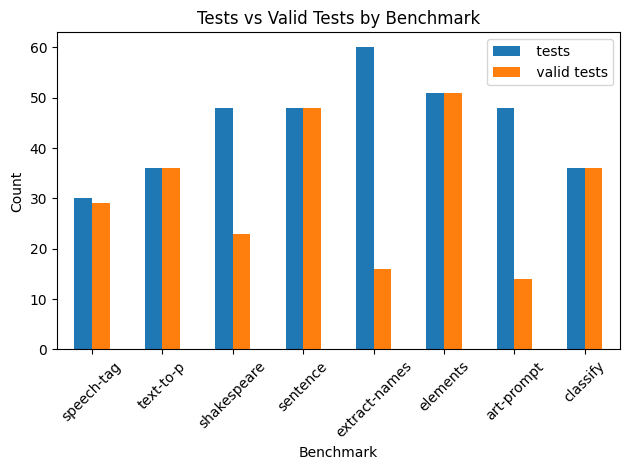

In [98]:
# Read the CSV file
df = pd.read_csv(f'evals/{benchmarkVersion}/pp-test-validity.csv')

# Plot the bar chart
fig, ax = plt.subplots()
df.plot(kind='bar', x='Benchmark', ax=ax)
ax.set_ylabel('Count')
ax.set_title('Tests vs Valid Tests by Benchmark')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

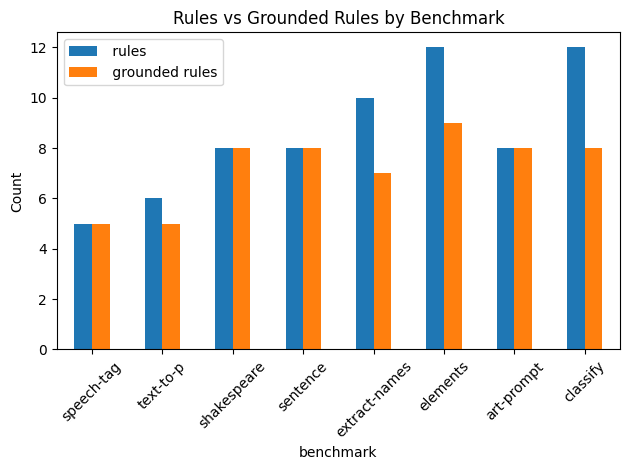

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv(f'evals/{benchmarkVersion}/pp-grounded-rules.csv')

# Plot the bar chart
fig, ax = plt.subplots()
df.plot(kind='bar', x='benchmark', ax=ax)
ax.set_ylabel('Count')
ax.set_title('Rules vs Grounded Rules by Benchmark')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()